# Time series prediction (Part 2)

**NB objectives**
- [ ] Get to use few prediction models
- [ ] Understand what CV is for

**Required librairies**
- [ ] matplotlib
- [ ] numpy
- [ ] pandas
- [ ] seaborn
- [ ] pmdarima

## Prediction models

### ARIMA

#### Theory behind

Le modèle ARMA (AutoRegressive Moving Average) ou ARMA (autorégressifs et moyenne mobile) en français, est un modèle adapté au prédiction sur toute série temporelle dont la valeur $Y$ à l'instant $t$ peut s'expliquer par les valeurs précédentes et les perturbations (bruits) précédentes.

Avant de préciser ce qu'est un jeu de donnée suivant le modèle ARIMA, précisons un jeu de donnée suivant les conditions :  

- **Autoregressif** : le modèle prédit la variable $Y$ à l'instant $t$, notée $Y_t$, à partir des valeurs précédentes de $Y$ selon un modèle de regression linéaire, c'est à dire $Y_{t-1}, Y_{t-2}, ..., Y_0$. On note $p$ le nombre de composantes utilisées pour prédire $Y_t$, avec

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, avec $\varepsilon_t$ une perturbation, et c une constante.

- **Moyenne mobile**: un modèle où les données sont le résultat de la moyenne mobile d'ordre $q$. Il est possible d'exprimer la valeur $Y_t$ à l'aide de la perturbation à l'instant $t$ et ses valeurs précédentes :

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, avec $\mu$ une constante.

Tout jeu de données ARIMA est la combinaison des conditions *AR* et *MA*, c'est à dire qu'il est autoregressif et son bruit suit une moyenne mobile. Soit :

> $Y_t =  c + \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t_q}$

ou :

> $Y_t - \sum_{i=1}^p \varphi_i Y_{t-i} = \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$ avec $\varepsilon_t$ l'erreur du modèle autoregressif à l'instant $t$.

Le modèle est optimisé à l'aide de la méthode des moindres carrées.


Un modèle ARMA est adapté à des jeux de données stationnaires, c'est à dire avec une moyenne et un écart type fixe au cours du temps. Il est rare que l'on observe de telles données. De nombreux jeux de données de séries temporelles présentent des tendances sur la moyenne ou encore des saisonnalités. Pour cela, il convient de stationnariser dans un premier temps le problème. On parle **d'intégration**. Un modèle **ARIMA** est dit :

- **intégré** : lorsqu'on peut corriger le jeu de donnée en réalisant le modèle sur $Y'_t = Y_t - Y_{t-1}$ pour une correction d'ordre 1 (d=1) ou encore $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ pour une correction d'ordre 2 (d=2), etc...  On note $d$ l'ordre de *correction par intégration* permet de supprimer les tendances polynomiales d'ordre $d$, avec:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$


Les modèles ARIMA sont souvent notés : ARIMA(p, d, q), soit **ARIMA(2, 1, 1)** signifie :
- un modèle autoregressif d'ordre 2,
- sur des données intégrées 1 fois,
- et avec une moyenne mobile d'ordre 1.

#### Bit of practice

##### Discover and prepare data

In [71]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm

In [72]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

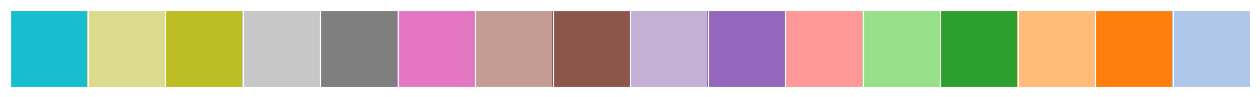

In [73]:
colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)
sns.set_style("darkgrid")

In [74]:
cwd = os.getcwd()
data_path = os.path.join(cwd, "data/AirPassengers.csv")

# Data import

## Import

In [75]:
df = pd.read_csv(data_path)

## Reworking

In [76]:
# Convert the "Month" column to datetime format
df["Month"] = pd.to_datetime(df["Month"])
# Set the "Month" column as the index
df.set_index("Month", inplace=True)
df = df.rename(columns={'#Passengers': 'Passengers'})

## Exploration

In [77]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [79]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Graphical Exploration

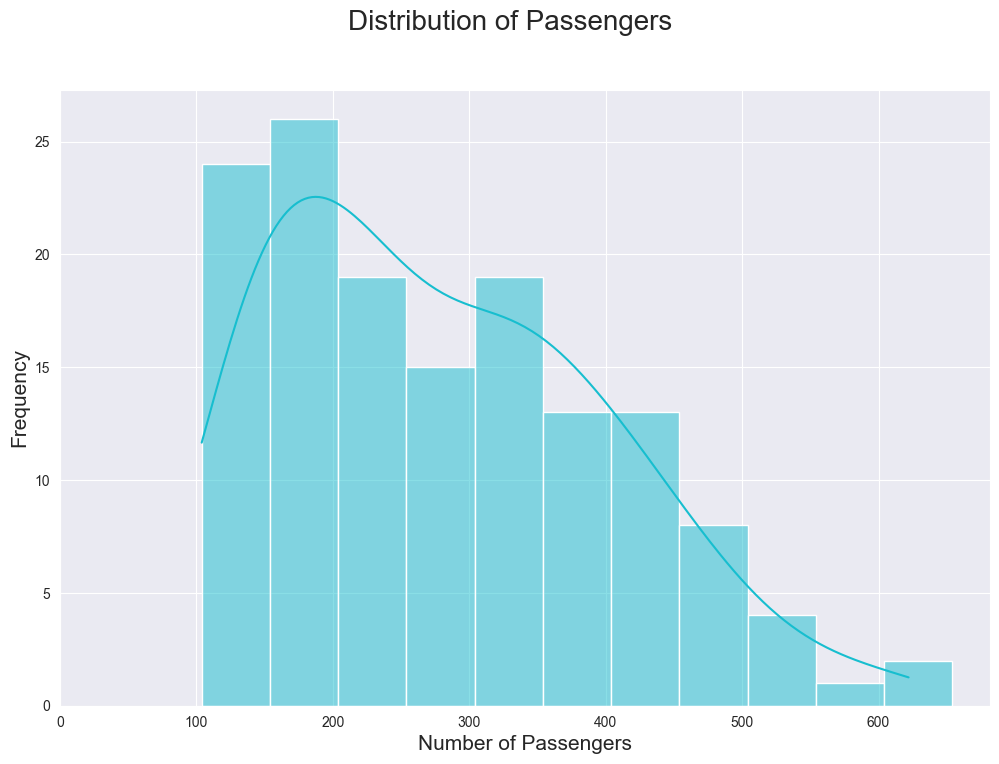

In [93]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
fig.suptitle("Distribution of Passengers", fontsize=20)

sns.histplot(
    ax=ax,
    data=df["Passengers"],
    kde=True,
    color=colors[0],
    binwidth=50
)

ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Number of Passengers", fontsize=15)

plt.xlim(0)

# Displaying the plot
plt.show()

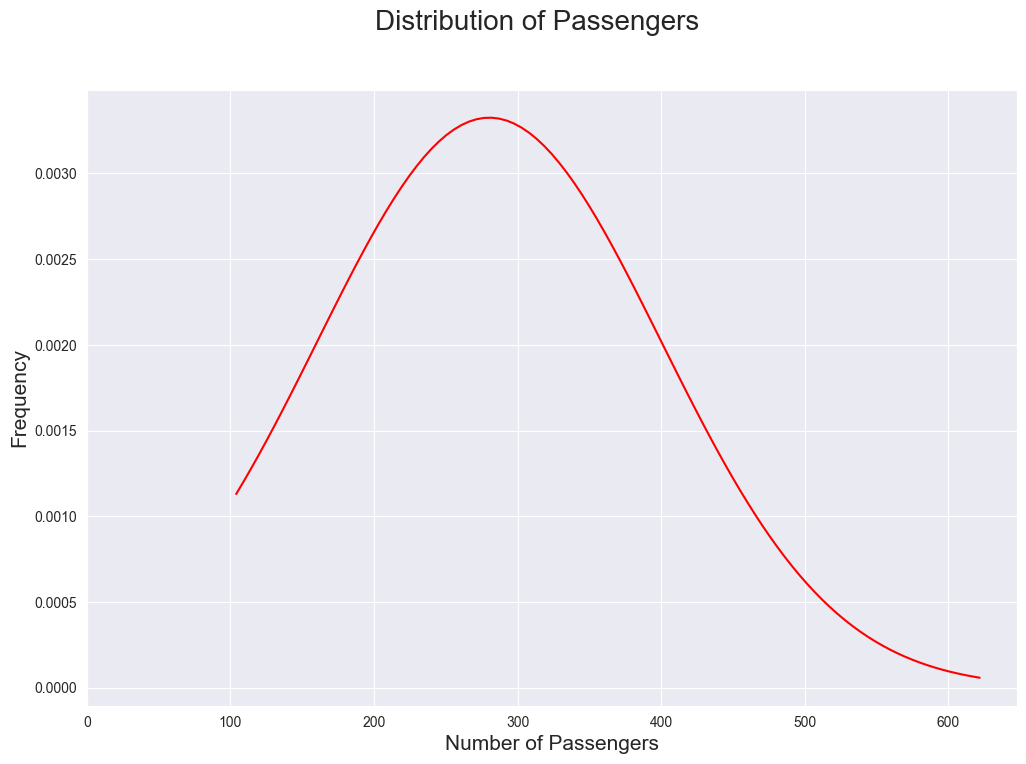

In [94]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
fig.suptitle("Distribution of Passengers", fontsize=20)

# Plotting the normal distribution curve
mean = df['Passengers'].mean()
std = df['Passengers'].std()
x = np.linspace(df['Passengers'].min(), df['Passengers'].max(), 100)
y = norm.pdf(x, mean, std)
ax.plot(x, y, color='r', label='Normal Distribution')
ax.set_ylabel('Density')

ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Number of Passengers", fontsize=15)

plt.xlim(0)

# Displaying the plot
plt.show()

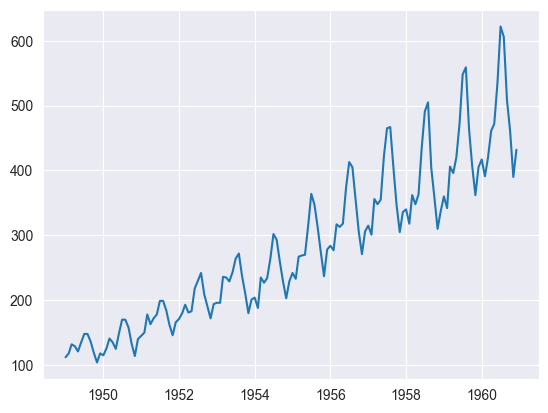

In [92]:
plt.plot(df["Passengers"])

In [ ]:
# Combined Plot to assess: 
# - "Données passagers", 
# - "Moyenne glissante" et 
# - "Deviation standard glissante"

**Conclusions:**
- Is this time serie stationary or not?
- What is its tendancy?
- What about heteroskedasticity?

In [ ]:
# Plot2: same infos as previously but with date on x axis and Y(t)-Y(t-1) on y axis
# Use airline.diff().values

**Observations:**
 - What about the stationarity?
 - What about the variance and how to deal with it?

In [ ]:
# Plot 2 with modification defined in your previous conclusion

**Observations:**
 - What about mean and deviation? Stationarity?
 
<span style="color:green">Then, it should be possible to apply ARIMA on these transformed data, with order 1 integration: ARIMA(p,1,q)</span>

##### Train/Test split challenges

In [1]:
# Explain why train/test split can be a challenge for time series

In [2]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [ ]:
# Hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline / airline.index.days_in_month, '1959-01-01')

In [ ]:
# Plot train and test sets

In [ ]:
# Do not forget to change your data (log)
train_adj_log = np.log(train)

Afin de valider les paramètres $p$ (*AR*) et $q$ (*MA*) du modèle ARIMA, l'on peut calculer l'auto-corrélation des données temporelles.
- Pour déterminer $p$ nous utiliserons l'autocorrelation des données par une donnée passée avec un décalage temporel (appelé *lag* en anglais). On utilisera pour cela la PACF (*Partial Auto Correlation Function*). La fonction PACF cherche à déterminer la correlation entre les données $Y_t$ et $Y_{t-i}$. La valeur de $p$ est déterminée par $PACF_i \approx 0$  
- pour déterminer $q$, on utilisera l'ACF (*Auto Correlation Function*). La fonction ACF calcule la correlation entre la série temporelle et elle-même avec un décalage temporel. Soit calculer la correlation de $Y_(t, t-1, ...)$ avec $Y_(t-i, t-i-1, ...)$.

In [ ]:
#ACF & PACF plots
from pmdarima.utils import acf, pacf

n_sample = len(train)
lag_acf = acf(np.log(train).diff().dropna(), nlags=25)
lag_pacf = pacf(np.log(train).diff().dropna(), nlags=25)

pct_95 = 1.96/np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
#Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray')
plt.axhline(y=pct_95, linestyle='--', color='gray')
# plt.axvline(x=q, color='black', linestyle='--', label=f'q={q}')
# plt.legend()
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray') # represent 95 % of a gaussian data
plt.axhline(y=pct_95, linestyle='--', color='gray') # represente 95 % of a gaussian data
# plt.axvline(x=p, color='black', linestyle='--', label=f'p={p}')
plt.title('Partial Autocorrelation Function')
# plt.legend()
plt.show()

**Observations**
- What can you tell about the correlation for ACF and PACF?
- Can you explain what you observe on this data (e.g. reasons for observed changes)?

<span style="color:red">
Even this model presents a seasonality, try modeling as ARIMA(1, 1, 1)
    </span>

In [ ]:
from pmdarima.arima import ARIMA

model = ARIMA(order=(12, 1, 12), suppress_warnings = True) # seasonal_order=(0, 1, 1, 12)
model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9));

In [ ]:
# Describe what you see on previous graphes
# Why diagnostics functions are usefull?

In [ ]:
# Use np.exp(prediction) to change log data back to "Normal"
plt.plot(train, label='Train')
plt.plot(test, label='Test')
y_pred, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')
plt.legend()
plt.show()

Now, find the error!

In [ ]:
from sklearn.metrics import mean_squared_error
#Calculate RMSE and RMSE/mean(test)

In [ ]:
# données connues
plt.plot(train, label='Train')
plt.plot(test, label='Test')

# prediction
y_pred, conf_int = model.predict(n_periods=100, return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')

plt.title('Prediction avec ARIMA')
plt.legend()
plt.show()

**Conclusions**
- Yours?
- What do you think about the error?

##### CV with ARIMA

In [ ]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [ ]:
#manually create the arima model
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [ ]:
cv = RollingForecastCV(h=HORIZON, step=10) # initially uses 1/3 of the training size

In [ ]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month
# airline_adj = np.log(airline_adj) # transform
train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model

cv_results = cross_val_score(model, train_log, cv=cv, scoring=mean_absolute_percentage_error)
print(cv_results)

In [ ]:
#how many splits did we get?
len(cv_results)

**TASK**
* go back and try different step values in the RollingForecastCV
* What changes?
* In each case what size is the data is the model training on?

##### Dealing now with seasonality: SARIMA

As previously seen, ARIMA model is for stationary data. It may even works for data presenting seasonality. However, seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode.

*eg:Data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of p=12*12 to comprehend seasonality of the problem.*

<span style="color: blue">Here comes SARIMA: Seasonal-ARIMA!</span>

In [6]:
# What are these parameters: (p,d,q) and (P,D,Q) ?

In [ ]:
# Make sure data form

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_std(a, n=3) :
    j = len(a) - n
    mov_std = np.array([np.std(a[k:k+n]) for k in range(j)])
    return mov_std

In [ ]:
# Plot data, trend, seasonal and random infos one by one using arima.decompose

In [ ]:
seasonal_data = decomposed.seasonal + decomposed.trend
seasonal_data = seasonal_data[~np.isnan(seasonal_data)]

plt.plot(np.diff(seasonal_data, 12), label='Seasonal data, cycle 12')
plt.plot(moving_average(seasonal_data, n=12), label='moving avg')
plt.plot(moving_std(seasonal_data, n=12), label='moving std')
plt.title('Seasonal data')
plt.legend()
plt.show()

non_seasonal_data = decomposed.random[~np.isnan(decomposed.random)]
plt.plot(non_seasonal_data, label='Intra seasonal data')
plt.plot(moving_average(non_seasonal_data, n=12), label='moving avg')
plt.plot(moving_std(non_seasonal_data, n=12), label='moving std')
plt.title('Intra seasonal data')
plt.legend()
plt.show()

**Observations**
- What can you conclude about stationarity of seasonal data? Can you then define D and freq?
- Does intra-seasonal data show specific seasonality? What is d (2, 1 or 0)?

In [ ]:
# Quote statistical tests to define stationarity

In [ ]:
freq = 12
ocsb_diffs = nsdiffs(
    train,
    test='ocsb',
    m=12, # time serie frequency
    max_D=12 # max D for seasonality
)
ch_diffs = nsdiffs(train, test='ch', m=freq, max_D=12)
n_diffs = max(ch_diffs, ocsb_diffs)
print(f'Here seasonality for supposed frequency of {freq} is {n_diffs=}')

In [ ]:
#ACF & PACF plots
from pmdarima.utils import acf, pacf

x = np.diff(seasonal_data)

n_sample = len(x)
lag_acf = acf(x, nlags=38)
lag_pacf = pacf(x, nlags=38)

pct_95 = 1.96/np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
#Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray')
plt.axhline(y=pct_95, linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray') 
plt.axhline(y=pct_95, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [ ]:
#Define q and p

In [ ]:
from pmdarima.arima import ARIMA

model = ARIMA(
    order=(8, 0, 4),
    seasonal_order=(0, 1, 1, 12), # 12 for monthly data
    suppress_warnings = True)
model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9));

In [ ]:
# données connues
plt.plot(train, label='Train')
plt.plot(test, label='Test')

# prediction
y_pred, conf_int = model.predict(n_periods=100, return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')

plt.title('Prediction avec ARIMA')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE and RMSE/mean(Test)

**Conclusions?**

##### What about Metrics?

https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

In [1]:
# Add your comments and notes

#### Automatize the analysis

**TODO - Write a class with the following methods:**
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

**Bonus:** 
* Add a method get_cv Which performs cross validation
* To further automatize the process add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit: such as a log transformation.

In [2]:
# Write your code here

**TODO - Test this method on all the other [11 datasets] of pmdarima**

https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets
To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [ ]:
import pmdarima

dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    return ds

In [ ]:
#### Write your code here

#### Want some more?

**data**: 
- choose your poison: https://data.world/datasets/time-series